# 8번
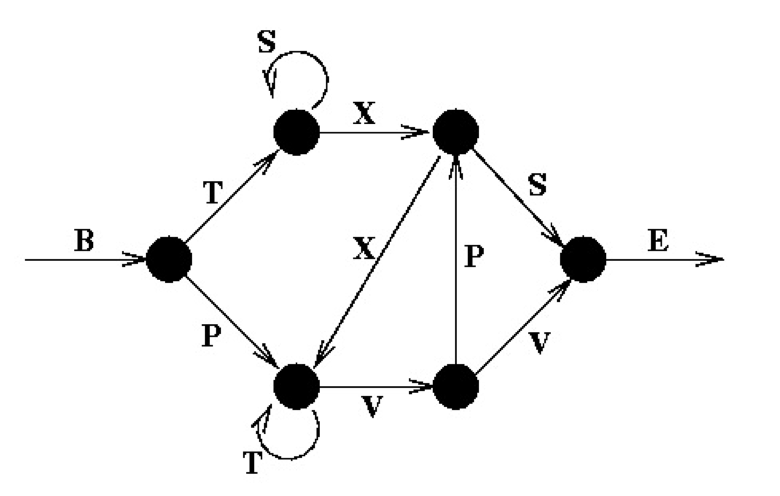

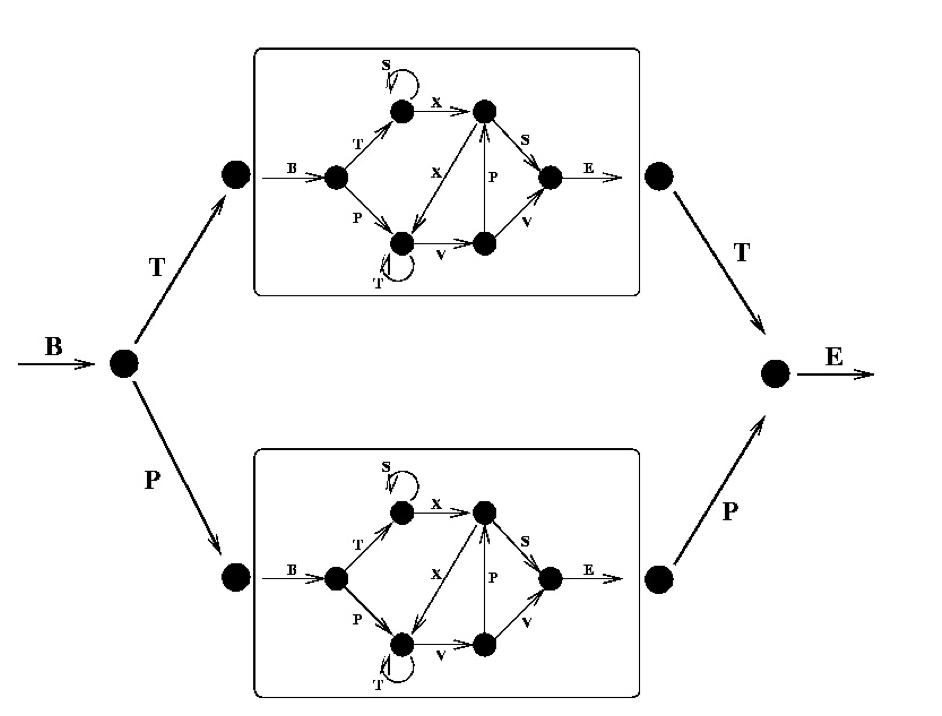

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

#reber grammar 생성 함수
def generate_string(grammar):
    state = 0
    output = [] 
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

In [3]:
np.random.seed(42)

#reber grammar를 따르는 25개의 단어 생성
for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [4]:
np.random.seed(42)

#embedded reber grammar를 따르는 25개의 단어 생성
for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [5]:
#reber grammar를 따르지 않는 함수 생성
POSSIBLE_CHARS = "BEPSTVX" #경로를 나타내는 가능한 알파벳들

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar) 
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [6]:
np.random.seed(42)

#reber grammar를 따르지 않는 단어 25개 생성
for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

### RNN에 입력하기 위해 단어들을 임베딩으로 바꾸기

In [7]:
#POSSIBLE_CHARS의 순서에 따라 ID부여하는 함수
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [8]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

In [9]:
#50%는 good strings, 50%는 bad strings를 나타내는 데이터셋 생성 함수
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [10]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [11]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

In [12]:
y_train[0]

array([1.])

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/gru/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/gru/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


313/313 [==============================] - 42s 123ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 38s 122ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 38s 122ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 36s 116ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 36s 115ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 36s 115ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 36s 115ms/step - loss: 0.3694 - accuracy: 0.8454 - val_loss: 0.3408 - val_accuracy: 0.8

In [14]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE", #bad string
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"] #good string
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.03%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.95%


###9번. 날짜 문자열 포맷을 변환하는 인코더-디코더 모델을 훈련하세요(예를 들어, 'Aprill 22, 2019'에서 '2019-04-22'로 바꿉니다).

### 데이터셋 준비

In [15]:
from datetime import date

# strftime()의 %B format은 설정 지역에 따라 한글, 영어 등 다르게 출력되기 때문에 사용 불가
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

#날짜 random생성
def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal() #1000-01-01부터
    max_date = date(9999, 12, 31).toordinal() #9999-12-31까지

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [16]:
#input format, target format 형태로 random 생성 날짜 출력
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [17]:
#가능한 Input characters 정의
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [18]:
#가능한 output characters 정의
OUTPUT_CHARS = "0123456789-"

In [19]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [20]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [22]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # 0을 padding으로 줌

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [23]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [24]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### version 1. basic seq2seq

* input sequence는 encoder를 통과해서 state vector를 이를 decoder에 넘겨줌 decoder는 vector sequence를 출력.

In [25]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1, 
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax") #output layer
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length), #decoder에 집어넣을 input을 decoder의 max output length만큼 반복
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 13s 22ms/step - loss: 1.8238 - accuracy: 0.3462 - val_loss: 1.3848 - val_accuracy: 0.4838
Epoch 2/20
313/313 [==============================] - 6s 18ms/step - loss: 1.2625 - accuracy: 0.5443 - val_loss: 1.1063 - val_accuracy: 0.6016
Epoch 3/20
313/313 [==============================] - 6s 19ms/step - loss: 0.9661 - accuracy: 0.6515 - val_loss: 0.8811 - val_accuracy: 0.6764
Epoch 4/20
313/313 [==============================] - 6s 19ms/step - loss: 0.9255 - accuracy: 0.6701 - val_loss: 0.7670 - val_accuracy: 0.7086
Epoch 5/20
313/313 [==============================] - 6s 18ms/step - loss: 0.7316 - accuracy: 0.7327 - val_loss: 0.5587 - val_accuracy: 0.7833
Epoch 6/20
313/313 [==============================] - 6s 18ms/step - loss: 0.4973 - accuracy: 0.8120 - val_loss: 0.5523 - val_accuracy: 0.7960
Epoch 7/20
313/313 [==============================] - 6s 18ms/step - loss: 0.3367 - accuracy: 0.8715 - val_loss: 0.2840 - val_accuracy: 0.891

In [26]:
#character ID들을 string으로 변환
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [27]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [28]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


In [29]:
len("September 17, 2009")

18

In [30]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [31]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-09-02
1789-01-14


In [45]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

## version 2. 교사 강요 사용
* 교사 강요는 이전 시점의 target을 이번 시점의 input으로 입력하는 방식이다. 이전 시점의 출력인 예측이 잘 못 되었을 경우 이번 시점에 엉뚱한 input이 들어오게 될 것이고 번역이 올바르지 않은 방향으로 흘러갈 것이다. 이를 방지하기 위해서 이번 시점의 input에 이전 시점의 target을 집어넣는다.

In [32]:
#decoder의 input 생성
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [33]:
#target을 한 칸씩 shift하고 sos가 앞에 삽입된 것을 확인할 수 있음
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

In [34]:
#10epoch만에 validation accuracy 100%에 도달했음(seq2seq보다 빠름).
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 11s 22ms/step - loss: 1.6803 - accuracy: 0.3743 - val_loss: 1.4172 - val_accuracy: 0.4506
Epoch 2/10
313/313 [==============================] - 6s 18ms/step - loss: 1.1891 - accuracy: 0.5588 - val_loss: 0.8894 - val_accuracy: 0.6730
Epoch 3/10
313/313 [==============================] - 6s 18ms/step - loss: 0.6307 - accuracy: 0.7748 - val_loss: 0.4162 - val_accuracy: 0.8539
Epoch 4/10
313/313 [==============================] - 6s 18ms/step - loss: 0.2116 - accuracy: 0.9476 - val_loss: 0.1125 - val_accuracy: 0.9815
Epoch 5/10
313/313 [==============================] - 6s 19ms/step - loss: 0.0715 - accuracy: 0.9913 - val_loss: 0.0461 - val_accuracy: 0.9970
Epoch 6/10
313/313 [==============================] - 6s 19ms/step - loss: 0.0680 - accuracy: 0.9893 - val_loss: 0.0276 - val_accuracy: 0.9990
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 0.0178 - accuracy: 0.9997 - val_loss: 0.0147 - val_accuracy: 0.999

In [43]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

### version 3. TF Addons seq2seq API 사용


In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/15
313/313 [==============================] - 13s 30ms/step - loss: 1.6778 - accuracy: 0.3657 - val_loss: 1.4651 - val_accuracy: 0.4271
Epoch 2/15
313/313 [==============================] - 9s 28ms/step - loss: 1.3794 - accuracy: 0.4618 - val_loss: 1.1807 - val_accuracy: 0.5543
Epoch 3/15
313/313 [==============================] - 9s 28ms/step - loss: 0.9574 - accuracy: 0.6449 - val_loss: 0.6447 - val_accuracy: 0.7751
Epoch 4/15
313/313 [==============================] - 9s 28ms/step - loss: 0.3974 - accuracy: 0.8755 - val_loss: 0.6728 - val_accuracy: 0.7954
Epoch 5/15
313/313 [==============================] - 9s 28ms/step - loss: 0.1182 - accuracy: 0.9829 - val_loss: 0.0621 - val_accuracy: 0.9962
Epoch 6/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0608 - accuracy: 0.9930 - val_loss: 0.0320 - val_accuracy: 0.9988
Epoch 7/15
313/313 [==============================] - 9s 28ms/step - loss: 0.0219 - accuracy: 0.9997 - val_loss: 0.0177 - val_accuracy: 0.999

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Training Sampler 대신 GreedyEmbeddingSampler를 사용하면 예측을 하기 위해 디코더를 한 번만 작동시키게 되므로 훨씬 효율적으로 추론이 가능하다.

In [ ]:
#inference model 정의
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [ ]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [ ]:
%timeit predict_date_strs(["July 14, 1789", "May 01, 2020"])

1 loop, best of 5: 383 ms per loop


In [ ]:
#GreedyEmbeddingSampler가 10배 정도 더 빠르다.
%timeit fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])

10 loops, best of 5: 38.4 ms per loop


### version4. TF-Addons seq2seq ScheduledEmbeddingSampler사용



In [ ]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(OUTPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_4:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_3:0", shape=(None, 32), dtype=float32), dense_shape=Tensor("gradient_tape/model_5/basic_decoder_3/decoder/while/gradients/model_5/basic_decoder_3/decoder/while/cond_1_grad/Identity_5:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_5/

313/313 [==============================] - 17s 42ms/step - loss: 1.6779 - accuracy: 0.3658 - val_loss: 1.4628 - val_accuracy: 0.4332
Epoch 2/20
313/313 [==============================] - 13s 41ms/step - loss: 1.4142 - accuracy: 0.4476 - val_loss: 1.3384 - val_accuracy: 0.4717
Epoch 3/20
313/313 [==============================] - 13s 41ms/step - loss: 1.1022 - accuracy: 0.5820 - val_loss: 0.8807 - val_accuracy: 0.6834
Epoch 4/20
313/313 [==============================] - 13s 42ms/step - loss: 0.6877 - accuracy: 0.7457 - val_loss: 0.4740 - val_accuracy: 0.8270
Epoch 5/20
313/313 [==============================] - 13s 41ms/step - loss: 0.3614 - accuracy: 0.8761 - val_loss: 0.2645 - val_accuracy: 0.9165
Epoch 6/20
313/313 [==============================] - 13s 41ms/step - loss: 0.2485 - accuracy: 0.9265 - val_loss: 0.1711 - val_accuracy: 0.9531
Epoch 7/20
313/313 [==============================] - 13s 41ms/step - loss: 0.1698 - accuracy: 0.9549 - val_loss: 0.1240 - val_accuracy: 0.9680
Epo

이 번엔 SampleEmbeddedSampler를 사용할 것이다. 모델의 output의 argmax를 통해 prediction을 하는게 아닌, output들을 logit으로 취급하고 토큰 ID를 random으로 sample한다. 셰익스피어와 같은 문장 만드는 법에서와 같이 문장을 생성할 떄 유용하다.

In [ ]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [ ]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [ ]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-00']

### version5. TFA seq2seq, Keras subclassing API, attention machanism 사용해 구현하기

In [ ]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/25
313/313 [==============================] - 19s 42ms/step - loss: 2.1368 - accuracy: 0.2335 - val_loss: 2.0080 - val_accuracy: 0.2648
Epoch 2/25
313/313 [==============================] - 13s 41ms/step - loss: 1.8487 - accuracy: 0.3307 - val_loss: 1.5100 - val_accuracy: 0.4396
Epoch 3/25
313/313 [==============================] - 13s 40ms/step - loss: 2.1037 - accuracy: 0.2437 - val_loss: 1.6046 - val_accuracy: 0.3954
Epoch 4/25
313/313 [==============================] - 13s 40ms/step - loss: 1.7171 - accuracy: 0.3651 - val_loss: 2.5416 - val_accuracy: 0.2658
Epoch 5/25
313/313 [==============================] - 13s 40ms/step - loss: 1.4480 - accuracy: 0.4810 - val_loss: 1.3507 - val_accuracy: 0.5063
Epoch 6/25
313/313 [==============================] - 13s 40ms/step - loss: 1.3200 - accuracy: 0.5156 - val_loss: 1.2034 - val_accuracy: 0.5402
Epoch 7/25
313/313 [==============================] - 13s 40ms/step - loss: 1.1148 - accuracy: 0.5612 - val_loss: 1.1936 - val_accuracy:

In [ ]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    Y_probas = model.predict([X, X_decoder])
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [ ]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])

['1789-06-14', '181805-015']

##10번. 텐서플로의 Neural Machine Translation with Attention tutorial(어텐션을 사용한 신경망 기계 번역) 튜토리얼을 살펴보세요.

## 11. 최신 언어 모델 중 하나(예를 들어 BERT)로 셰익스피어가 쓴 것 같은 텍스트를 생성해보세요.

In [36]:
pip install transformers

     |████████████████████████████████| 3.1 MB 5.5 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 895 kB 47.6 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 34.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [37]:
#훈련된 GPT model load
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/656 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


In [38]:
from transformers import OpenAIGPTTokenizer

#tokenizer import
tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

Downloading:   0%|          | 0.00/797k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/448k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [39]:
#token화 
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [40]:
#주어진 문장에 40개의 토큰을 추가해 5개의 문장 만들기

num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239, 40477,   244,   481,  2761,  7994,   587,   595,
         2985,   512,   557,   246,  4815,   239,   481,  2676,   544,
          617,   704,  1377,   239,   244,     8, 24294,   603,   239,
        40477,   244,   249,  1048,  1458,   562,   481, 21200,   240,
          568,   718,   759,   600,   604],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   487,   759,   808,  1777,   485,  1300,   481,
         2873,   498,   507,  1990,   246,  6560, 21467,   240,  1389,
          557, 29616,   239, 29616,   558,   728,  5055,   491,  1279,
          271,   524,  1158,   535,  1163,   240,   524,  7590,   240,
          488,   524, 33651,   498,   517],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   636,   580,   481, 24721,   488,   905,  2589,   520,
          558

In [41]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle. 
 " the sea folk do not wear you as a princess. the magic is from your blood. " ahab said. 
 " i am sorry for the orcs, but how can they have
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. he can only hope to turn the weight of it towards a worthy adversary, such as claudio. claudio had other matters at heart : his father's home, his territory, and his armada of at
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle would be the richest and most comfortable she had ever come across. 
 her lady's guards stopped the marching and bowing, held the queen's hand. 
 " lady - king decanus is a
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, he was it. but he was sure that if he gave up his mortal form for the fu